(p,n,k+l,T) =  (1000, 10, 10, 400) 



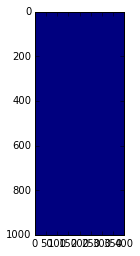

run 1/1


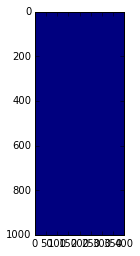


 - multiple lags
starting descent
finished % 10.0
f =  147277.308767
finished % 20.0
f =  25275.5101812
finished % 30.0
f =  10530.5684225
finished % 40.0
f =  7916.36155595
finished % 50.0
f =  7415.8866912
finished % 60.0
f =  5631.05737554
finished % 70.0
f =  4879.79358845
finished % 80.0
f =  4229.67480031
finished % 90.0
f =  3705.08538987
finished % 100.0
f =  3490.64558053
total iterations:  1950
starting descent
finished % 10.0
f =  3216.67078293
finished % 20.0
f =  2993.8439255
finished % 30.0
f =  2871.89306056
finished % 40.0
f =  2797.25924088
finished % 50.0
f =  2753.59725618
finished % 60.0
f =  2719.69038275
finished % 70.0
f =  2686.77715785
finished % 80.0
f =  2663.34166255
finished % 90.0
f =  2644.40995089
finished % 100.0
f =  2630.5280287
total iterations:  60
m = 0, corr = 0.854218141603
m = 1, corr = 0.838616716919
m = 2, corr = 0.828880326465
m = 3, corr = 0.827485443275
m = 4, corr = 0.827144246619
m = 5, corr = 0.804997570178
m = 6, corr = 0.795406135464


/home/mackelab/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2151: RuntimeWarning: invalid value encountered in true_divide
  return c / sqrt(multiply.outer(d, d))


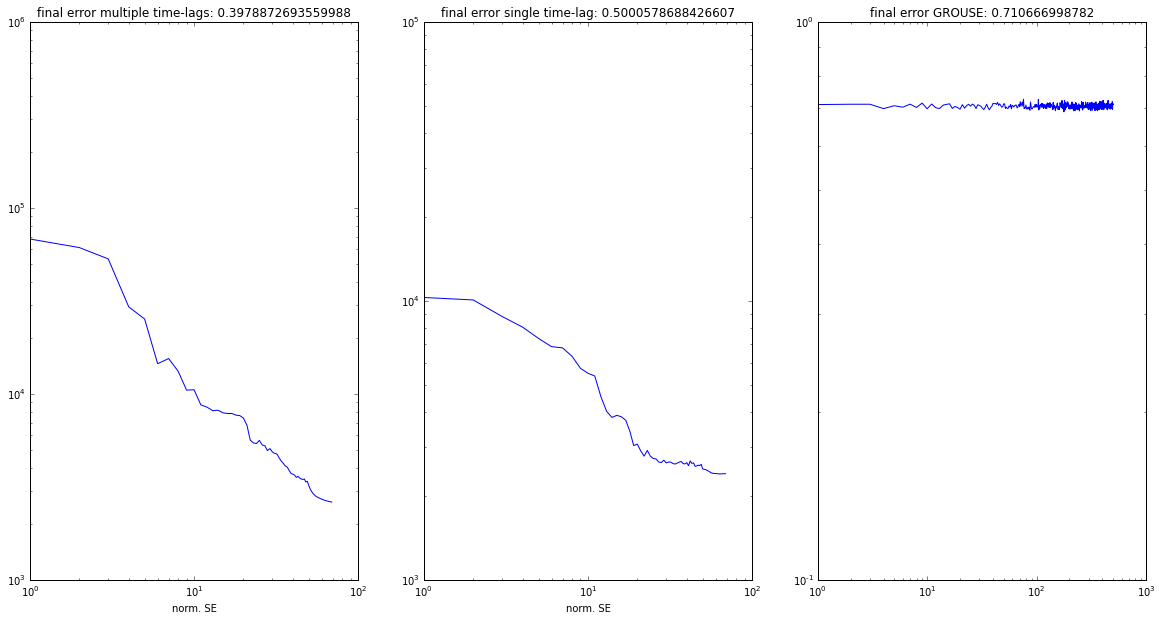

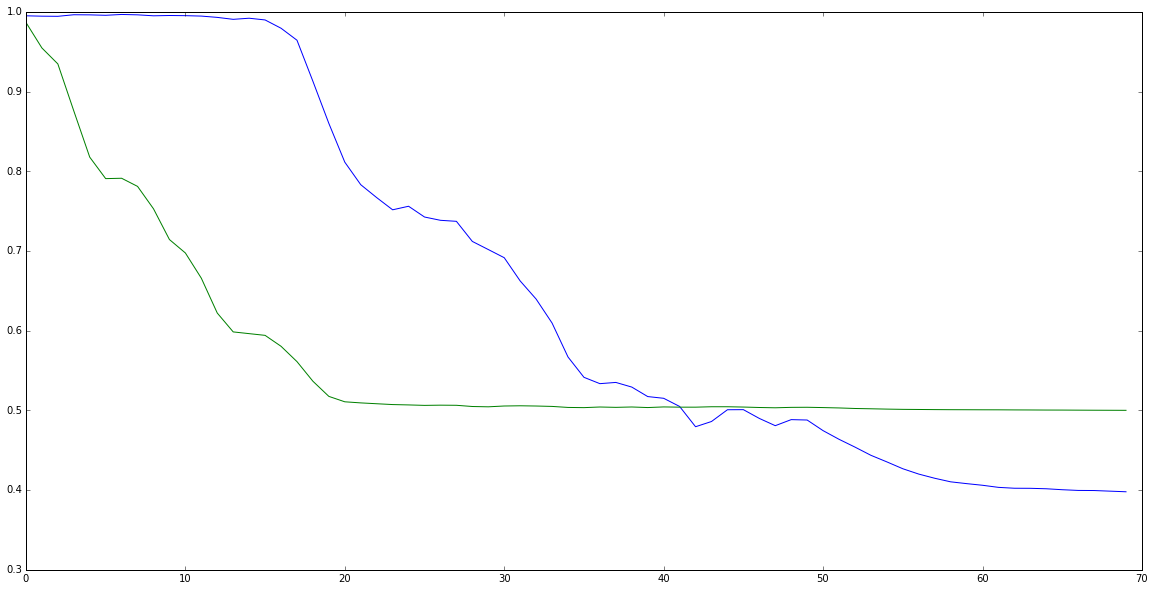

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os, psutil, time

from ssidid.SSID_Hankel_loss import run_bad, plot_slim, print_slim, f_l2_Hankel_nl
from ssidid.utility import get_subpop_stats, gen_data
from ssidid import ObservationScheme
from subtracking import Grouse, calc_subspace_proj_error

data_path = '/home/mackelab/Desktop/Projects/Stitching/code/le_stitch/python/fits/compare_vs_grouse/'

#np.random.seed(0)

# define problem size
p, n, T = 1000, 10, 400
lag_range_full = np.arange(10)
lag_range = lag_range_full.copy()
kl_ = np.max(lag_range)+1

nr = 0 # number of real eigenvalues
snr = (3., 3.)
whiten = True
eig_m_r, eig_M_r, eig_m_c, eig_M_c = 0.90, 0.95, 0.90, 0.95

print('(p,n,k+l,T) = ', (p,n,len(lag_range),T), '\n')

# I/O matter
mmap, chunksize = False, np.min((p,2000))
verbose=True

# create subpopulations
sub_pops = (np.arange(0,p), np.arange(0,p))
obs_pops = np.array([0,1])
obs_time = np.array([T//2,T])

obs_idx, idx_grp, co_obs, _, _, _, Om, _, _ = \
    get_subpop_stats(sub_pops=sub_pops, p=p, verbose=False)

obs_scheme = ObservationScheme(p=p, T=T, 
                               sub_pops=sub_pops, obs_pops=obs_pops, 
                               obs_time=obs_time, obs_idx=obs_time, 
                               idx_grp=idx_grp)

    
# settings for quick initial SGD fitting phase for our model
batch_size, max_zip_size, max_iter = 10, np.inf, 50
a, b1, b2, e = 0.01, 0.99, 0.99, 1e-8
a_R = 1 * a

# settings for quick initial SGD fitting phase for our model
batch_size_late, max_zip_size_late, max_iter_late = 100, np.inf, 20
a_late, b1_late, b2_late, e_late = 0.005, 0.9, 0.99, 1e-8
a_R_late = 1 * a_late
    
# settings for GROUSE
a_grouse = 0.002
max_iter_grouse = 500


mask = np.zeros((T,p))
for t in range(T):
    for i in range(len(obs_time)):
        if t < obs_time[i]:
            mask[t,sub_pops[obs_pops[i]]] = 1
            break
        
obs_scheme.mask = mask
plt.imshow(mask.T)
plt.show()

num_runs = 1
res = np.zeros((num_runs, 3))
rgt = np.zeros((num_runs, 2))
for run in range(num_runs):
    
    print('run ' + str(run+1) + '/' + str(num_runs))
    
    # draw system matrices 
    lag_range = lag_range_full.copy()
    pars_true, x, y, Qs, idx_a, idx_b = gen_data(p,n,lag_range,T, nr,
                                                 eig_m_r, eig_M_r, 
                                                 eig_m_c, eig_M_c,
                                                 mmap, chunksize,
                                                 data_path,
                                                 snr=snr, whiten=whiten)    
    
    mask = np.ones((T,p))
    #for t in range(T):
    #    mask[t,np.random.choice(p,num_unobs,replace=False)] = 0
    obs_scheme.mask = mask
    plt.imshow(mask.T)
    plt.show()
    
    pars_true['X'] = np.vstack([np.linalg.matrix_power(pars_true['A'],k).dot(pars_true['Pi']) for k in lag_range_full])

    # fit our model with multiple time-lags
    print('\n - multiple lags')
    pars_est_m = 'default'
    t = time.time()
    
    proj_errors = np.zeros((max_iter, 2))
    def pars_track(C,X,R,t): 
        proj_errors[t,0] = calc_subspace_proj_error(pars_true['C'], C)
    _, pars_est_m, traces_m = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
                                          obs_scheme=obs_scheme,init=pars_est_m,
                                          alpha_C=a,alpha_R=a_R,b1_C=b1,b2_C=b2,e_C=e,max_iter=max_iter,
                                          batch_size=batch_size,verbose=verbose, max_zip_size=max_zip_size,
                                          pars_track=pars_track)
    proj_errors_late = np.zeros((max_iter_late, 2))    
    def pars_track(C,X,R,t): 
        proj_errors_late[t,0] = calc_subspace_proj_error(pars_true['C'], C)
    _, pars_est_m, traces_m2 = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
                                          obs_scheme=obs_scheme,init=pars_est_m,
                                          alpha_C=a_late,alpha_R=a_R_late,b1_C=b1_late,b2_C=b2_late,e_C=e_late,
                                          max_iter=max_iter_late,batch_size=batch_size_late,
                                          verbose=verbose, max_zip_size=max_zip_size_late,pars_track=pars_track)
    traces_m = (np.hstack((traces_m[0], traces_m2[0])), np.hstack((traces_m[1], traces_m2[1])))
    t_m = time.time() - t
    print_slim(Qs,lag_range,pars_est_m,idx_a,idx_b,traces_m,mmap,data_path)
    print('fitting time was ', t_m, 's')
    print('rank of final C_est: ', sp.linalg.orth(pars_est_m['C']).shape[1])
    print('final proj. error: ', str(calc_subspace_proj_error(pars_true['C'], pars_est_m['C'])))

    rgt[run, 0] = f_l2_Hankel_nl(C=pars_true['C'],
                                 X=np.vstack([np.cov(x[k_:-(kl_+1)+k_, :].T, x[:-(kl_+1), :].T)[:n,n:] for k_ in lag_range]),
                                 Pi=np.cov(x.T),
                                 R=pars_true['R'],lag_range=lag_range,Qs=Qs,
                                 idx_grp=idx_grp,co_obs=co_obs,idx_a=idx_a,idx_b=idx_b)
    print('final error: ' + str(traces_m[0][-1]))    
    print('ground-truth reference error: ' + str(rgt[run,0]))


    # fit our model with single time-lag    
    print('\n - single lag')
    lag_range, pars_est_s = np.array([0]), 'default'
    t = time.time()
    def pars_track(C,X,R,t): 
        proj_errors[t,1] = calc_subspace_proj_error(pars_true['C'], C)
    
    _, pars_est_s, traces_s = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
                                          obs_scheme=obs_scheme,init=pars_est_s,
                                          alpha_C=a,alpha_R=a_R,b1_C=b1,b2_C=b2,e_C=e,max_iter=max_iter,batch_size=batch_size,
                                          verbose=verbose, max_zip_size=max_zip_size,pars_track=pars_track)
    def pars_track(C,X,R,t): 
        proj_errors_late[t,1] = calc_subspace_proj_error(pars_true['C'], C)
    _, pars_est_s, traces_s2 = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
                                          obs_scheme=obs_scheme,init=pars_est_s,
                                          alpha_C=a_late,alpha_R=a_R_late,b1_C=b1_late,b2_C=b2_late,e_C=e_late,
                                          max_iter=max_iter_late,batch_size=batch_size_late,
                                          verbose=verbose, max_zip_size=max_zip_size_late,pars_track=pars_track)
    traces_s = (np.hstack((traces_s[0], traces_s2[0])), np.hstack((traces_s[1], traces_s2[1])))
    proj_errors = np.vstack((proj_errors, proj_errors_late))
    t_s = time.time() - t
    print_slim(Qs,lag_range,pars_est_s,idx_a,idx_b,traces_s,mmap,data_path)
    print('fitting time was ', t_s, 's')
    print('rank of final C_est: ', sp.linalg.orth(pars_est_s['C']).shape[1])
    print('final proj. error: ', str(calc_subspace_proj_error(pars_true['C'], pars_est_s['C'])))

    rgt[run, 1] = f_l2_Hankel_nl(C=pars_true['C'],
                                 X=np.vstack([np.cov(x[k_:-(kl_+1)+k_, :].T, x[:-(kl_+1), :].T)[:n,n:] for k_ in lag_range]),
                                 Pi=np.cov(x.T),
                                 R=pars_true['R'],lag_range=lag_range,Qs=Qs,
                                 idx_grp=idx_grp,co_obs=co_obs,idx_a=idx_a,idx_b=idx_b)    
    
    print('final error: ' + str(traces_s[0][-1]))        
    print('ground-truth reference error: ' + str(rgt[run,1]))

    # fit GROUSE
    t = time.time()
    print('\n - GROUSE')
    tracker = Grouse(p, n, a_grouse )
    error = np.zeros(max_iter_grouse)
    for i in range(max_iter_grouse):
        if verbose and np.mod(i,max_iter_grouse//10) == 0:
            print('finished % ' + str((100*i)//max_iter_grouse))
        idx = np.random.permutation(T)
        for j in range(T):
            tracker.consume(y[idx[j],:].reshape(p,1), mask[idx[j],:].reshape(p,1))

        error[i] = calc_subspace_proj_error(pars_true['C'], tracker.U)
    t_g = time.time() - t
    pars_est_g = {'C' : tracker.U}
    
    
    res[run,:] = np.array([ calc_subspace_proj_error(pars_true['C'], pars_est_m['C']),
                            calc_subspace_proj_error(pars_true['C'], pars_est_s['C']),
                            error[-1]])
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.loglog(traces_m[0])
    plt.xlabel('norm. SE')
    plt.title('final error multiple time-lags: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_m['C'])))    
    plt.subplot(1,3,2)
    plt.loglog(traces_s[0])
    plt.xlabel('norm. SE')
    plt.title('final error single time-lag: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_s['C'])))
    plt.subplot(1,3,3)
    plt.loglog(range(1,max_iter_grouse+1), error)
    plt.title('final error GROUSE: ' + str(error[-1]))
    plt.show()
    
    plt.figure(figsize=(20,10))
    plt.plot(proj_errors[:,0])
    plt.hold(True)
    plt.plot(proj_errors[:,1])
    plt.show()

    save_dict = {'p' : p,
                 'n' : n,
                 'T' : T,
                 'snr' : snr,
                 'obs_scheme' : obs_scheme,
                 'lag_range' : lag_range_full,
                 'x' : x,
                 'y' : y,
                 'pars_true' : pars_true,
                 'pars_est_s' : pars_est_s,
                 'pars_est_m' : pars_est_m,
                 'pars_est_g' : pars_est_g,
                 'res' : res,
                 'rgt' : rgt,
                 't_s' : t_s,
                 't_m' : t_m,
                 't_g' : t_g,
                 'traces_m' : traces_m,
                 'traces_s' : traces_s,
                 'traces_g' : error
                }
    file_name = 'p' + str(p) + 'n' + str(n) + 'T' + str(T) + 'snr' + str(np.int(np.mean(snr)//1)) + '_run' + str(run) + '_partial_dat'
    #np.savez(data_path + file_name, save_dict)

    


 - GROUSE
finished % 0
finished % 10
finished % 20
finished % 30
finished % 40
finished % 50
finished % 60
finished % 70
finished % 80
finished % 90


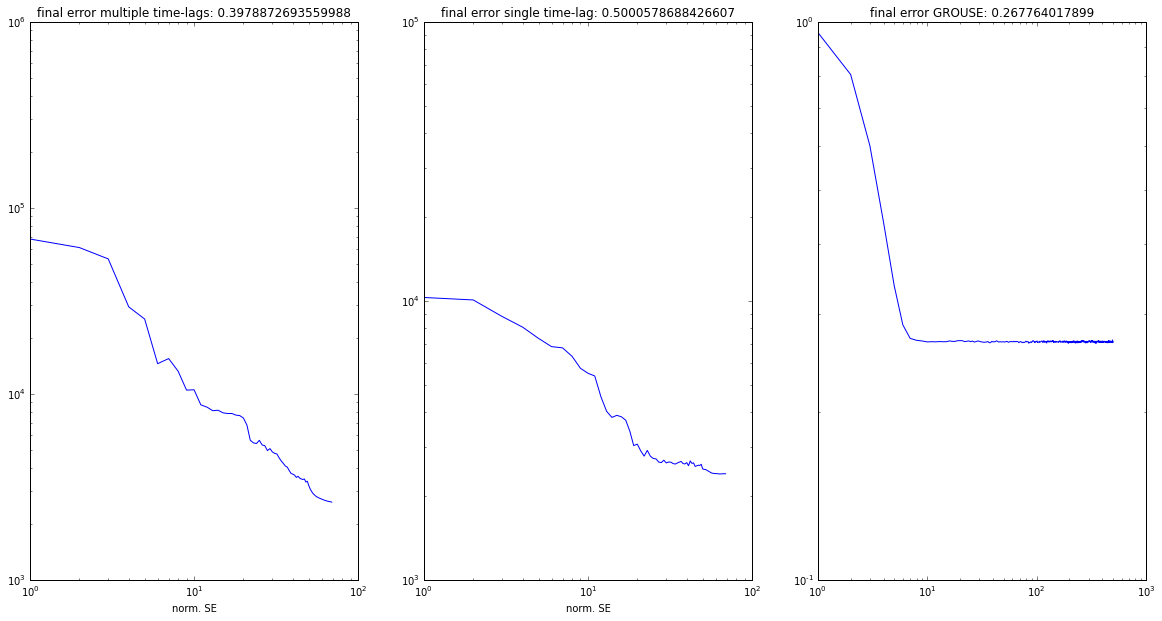

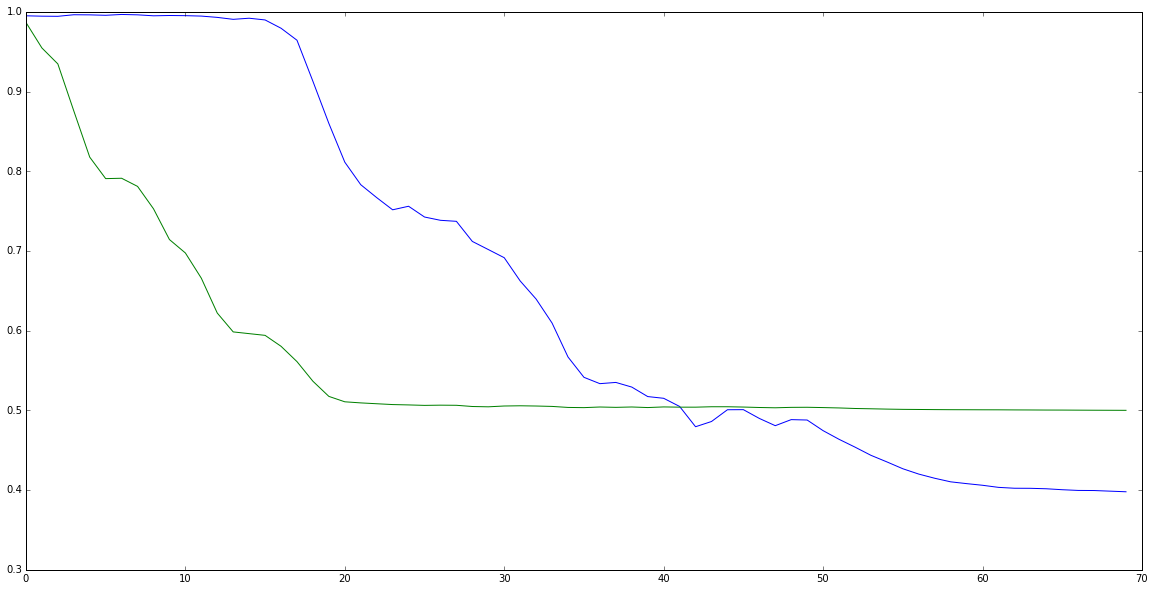

In [2]:
    # settings for GROUSE
    a_grouse = 0.0001
    max_iter_grouse = 500

    # fit GROUSE
    t = time.time()
    print('\n - GROUSE')
    tracker = Grouse(p, n, a_grouse )
    error = np.zeros(max_iter_grouse)
    for i in range(max_iter_grouse):
        if verbose and np.mod(i,max_iter_grouse//10) == 0:
            print('finished % ' + str((100*i)//max_iter_grouse))
        idx = np.random.permutation(T)
        for j in range(T):
            tracker.consume(y[idx[j],:].reshape(p,1), mask[idx[j],:].reshape(p,1))

        error[i] = calc_subspace_proj_error(pars_true['C'], tracker.U)
    t_g = time.time() - t
    pars_est_g = {'C' : tracker.U}
    
    
    res[run,:] = np.array([ calc_subspace_proj_error(pars_true['C'], pars_est_m['C']),
                            calc_subspace_proj_error(pars_true['C'], pars_est_s['C']),
                            error[-1]])
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.loglog(traces_m[0])
    plt.xlabel('norm. SE')
    plt.title('final error multiple time-lags: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_m['C'])))    
    plt.subplot(1,3,2)
    plt.loglog(traces_s[0])
    plt.xlabel('norm. SE')
    plt.title('final error single time-lag: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_s['C'])))
    plt.subplot(1,3,3)
    plt.loglog(range(1,max_iter_grouse+1), error)
    plt.title('final error GROUSE: ' + str(error[-1]))
    plt.show()
    
    plt.figure(figsize=(20,10))
    plt.plot(proj_errors[:,0])
    plt.hold(True)
    plt.plot(proj_errors[:,1])
    plt.show()


 - multiple lags
starting descent
finished % 10.0
f =  2438.89540235
finished % 20.0
f =  2358.62003086
finished % 30.0
f =  2293.8522978
finished % 40.0
f =  2223.94623534
finished % 50.0
f =  2148.20648684
finished % 60.0
f =  2069.2820836
finished % 70.0
f =  2020.81827483
finished % 80.0
f =  1970.2660863
finished % 90.0
f =  1915.51820887
finished % 100.0
f =  1886.06996134
total iterations:  500
m = 0, corr = 0.915748140499
m = 1, corr = 0.910203784416
m = 2, corr = 0.901105425293
m = 3, corr = 0.892257662764
m = 4, corr = 0.876259312055
m = 5, corr = 0.867190242797
m = 6, corr = 0.848116098623
m = 7, corr = 0.826408408641
m = 8, corr = 0.821488572122
m = 9, corr = 0.772910776984
fitting time was  408.271591424942 s
rank of final C_est:  10
final proj. error:  0.27963552274284226
final error: 1862.7641667
ground-truth reference error: 2517.08170748

 - single lag
starting descent
finished % 10.0
f =  2392.57699748
finished % 20.0
f =  2367.39301422
finished % 30.0
f =  2369.5786

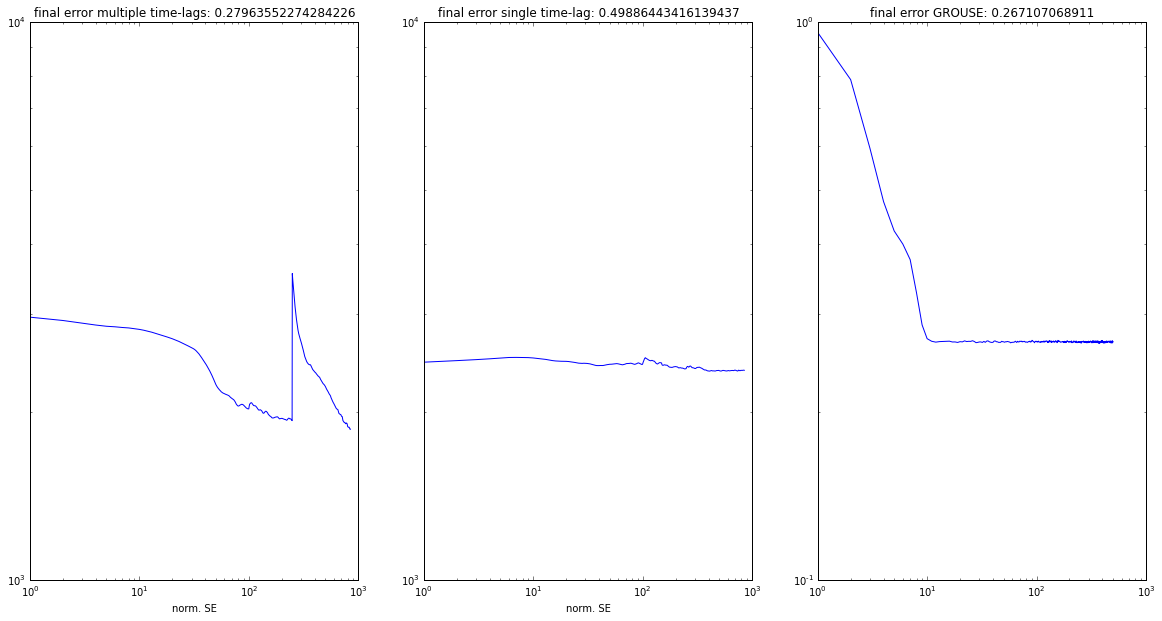

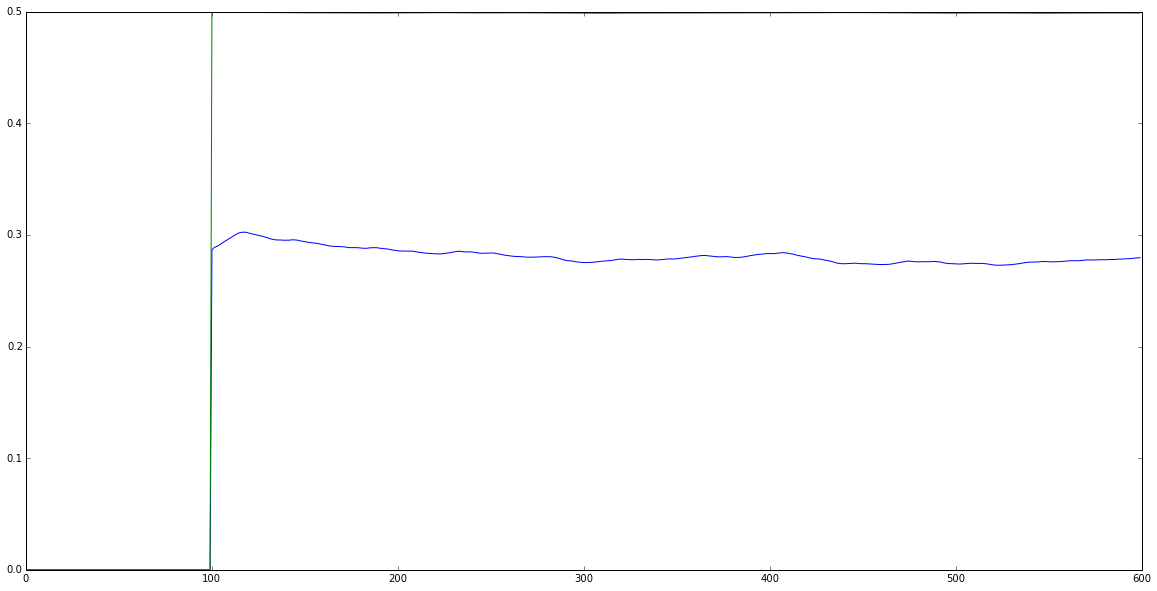

In [7]:
    # settings for quick initial SGD fitting phase for our model
    batch_size_late, max_zip_size_late, max_iter_late = 200, np.inf, 500
    a_late, b1_late, b2_late, e_late = 0.0025, 0.9, 0.99, 1e-8
    a_R_late = 1 * a_late

    # fit our model with multiple time-lags
    print('\n - multiple lags')
    t = time.time()
    lag_range = lag_range_full.copy()
    proj_errors = np.zeros((max_iter, 2))
    def pars_track(C,X,R,t): 
        proj_errors[t,0] = calc_subspace_proj_error(pars_true['C'], C)
    #_, pars_est_m, traces_m = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
    #                                      obs_scheme=obs_scheme,init=pars_est_m,
    #                                      alpha_C=a,alpha_R=a_R,b1_C=b1,b2_C=b2,e_C=e,max_iter=max_iter,
    #                                      batch_size=batch_size,verbose=verbose, max_zip_size=max_zip_size,
    #                                      pars_track=pars_track)
    proj_errors_late = np.zeros((max_iter_late, 2))    
    def pars_track(C,X,R,t): 
        proj_errors_late[t,0] = calc_subspace_proj_error(pars_true['C'], C)
    _, pars_est_m, traces_m2 = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
                                          obs_scheme=obs_scheme,init=pars_est_m,
                                          alpha_C=a_late,alpha_R=a_R_late,b1_C=b1_late,b2_C=b2_late,e_C=e_late,
                                          max_iter=max_iter_late,batch_size=batch_size_late,
                                          verbose=verbose, max_zip_size=max_zip_size_late,pars_track=pars_track)
    traces_m = (np.hstack((traces_m[0], traces_m2[0])), np.hstack((traces_m[1], traces_m2[1])))
    t_m = time.time() - t
    print_slim(Qs,lag_range,pars_est_m,idx_a,idx_b,traces_m,mmap,data_path)
    print('fitting time was ', t_m, 's')
    print('rank of final C_est: ', sp.linalg.orth(pars_est_m['C']).shape[1])
    print('final proj. error: ', str(calc_subspace_proj_error(pars_true['C'], pars_est_m['C'])))

    rgt[run, 0] = f_l2_Hankel_nl(C=pars_true['C'],
                                 X=np.vstack([np.cov(x[k_:-(kl_+1)+k_, :].T, x[:-(kl_+1), :].T)[:n,n:] for k_ in lag_range]),
                                 Pi=np.cov(x.T),
                                 R=pars_true['R'],lag_range=lag_range,Qs=Qs,
                                 idx_grp=idx_grp,co_obs=co_obs,idx_a=idx_a,idx_b=idx_b)
    print('final error: ' + str(traces_m[0][-1]))    
    print('ground-truth reference error: ' + str(rgt[run,0]))


    # fit our model with single time-lag    
    print('\n - single lag')
    lag_range = np.array([0])
    t = time.time()
    def pars_track(C,X,R,t): 
        proj_errors[t,1] = calc_subspace_proj_error(pars_true['C'], C)
    
    #_, pars_est_s, traces_s = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
    #                                      obs_scheme=obs_scheme,init=pars_est_s,
    #                                      alpha_C=a,alpha_R=a_R,b1_C=b1,b2_C=b2,e_C=e,max_iter=max_iter,batch_size=batch_size,
    #                                      verbose=verbose, max_zip_size=max_zip_size,pars_track=pars_track)
    def pars_track(C,X,R,t): 
        proj_errors_late[t,1] = calc_subspace_proj_error(pars_true['C'], C)
    _, pars_est_s, traces_s2 = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
                                          obs_scheme=obs_scheme,init=pars_est_s,
                                          alpha_C=a_late,alpha_R=a_R_late,b1_C=b1_late,b2_C=b2_late,e_C=e_late,
                                          max_iter=max_iter_late,batch_size=batch_size_late,
                                          verbose=verbose, max_zip_size=max_zip_size_late,pars_track=pars_track)
    traces_s = (np.hstack((traces_s[0], traces_s2[0])), np.hstack((traces_s[1], traces_s2[1])))
    proj_errors = np.vstack((proj_errors, proj_errors_late))
    t_s = time.time() - t
    print_slim(Qs,lag_range,pars_est_s,idx_a,idx_b,traces_s,mmap,data_path)
    print('fitting time was ', t_s, 's')
    print('rank of final C_est: ', sp.linalg.orth(pars_est_s['C']).shape[1])
    print('final proj. error: ', str(calc_subspace_proj_error(pars_true['C'], pars_est_s['C'])))

    rgt[run, 1] = f_l2_Hankel_nl(C=pars_true['C'],
                                 X=np.vstack([np.cov(x[k_:-(kl_+1)+k_, :].T, x[:-(kl_+1), :].T)[:n,n:] for k_ in lag_range]),
                                 Pi=np.cov(x.T),
                                 R=pars_true['R'],lag_range=lag_range,Qs=Qs,
                                 idx_grp=idx_grp,co_obs=co_obs,idx_a=idx_a,idx_b=idx_b)    
    
    print('final error: ' + str(traces_s[0][-1]))        
    print('ground-truth reference error: ' + str(rgt[run,1]))
    
    res[run,:] = np.array([ calc_subspace_proj_error(pars_true['C'], pars_est_m['C']),
                            calc_subspace_proj_error(pars_true['C'], pars_est_s['C']),
                            error[-1]])
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.loglog(traces_m[0])
    plt.xlabel('norm. SE')
    plt.title('final error multiple time-lags: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_m['C'])))    
    plt.subplot(1,3,2)
    plt.loglog(traces_s[0])
    plt.xlabel('norm. SE')
    plt.title('final error single time-lag: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_s['C'])))
    plt.subplot(1,3,3)
    plt.loglog(range(1,max_iter_grouse+1), error)
    plt.title('final error GROUSE: ' + str(error[-1]))
    plt.show()
    
    plt.figure(figsize=(20,10))
    plt.plot(proj_errors[:,0])
    plt.hold(True)
    plt.plot(proj_errors[:,1])
    plt.show()


 - multiple lags
starting descent
finished % 10.0
f =  1753.93658335
finished % 20.0
f =  1738.77133707
finished % 30.0
f =  1737.92504291
finished % 40.0
f =  1736.93182179
finished % 50.0
f =  1737.43176666
finished % 60.0
f =  1739.88851586
finished % 70.0
f =  1737.27179628
finished % 80.0
f =  1736.6911032
finished % 90.0
f =  1737.11009777
finished % 100.0
f =  1737.04781444
total iterations:  500
m = 0, corr = 0.930794083467
m = 1, corr = 0.915971581373
m = 2, corr = 0.906882638601
m = 3, corr = 0.896482775014
m = 4, corr = 0.884072848911
m = 5, corr = 0.86991942855
m = 6, corr = 0.853769366461
m = 7, corr = 0.838924614162
m = 8, corr = 0.823197279863
m = 9, corr = 0.806688638528
fitting time was  615.2578375339508 s
rank of final C_est:  10
final proj. error:  0.273258744185611
final error: 1736.81238854
ground-truth reference error: 2517.08170748


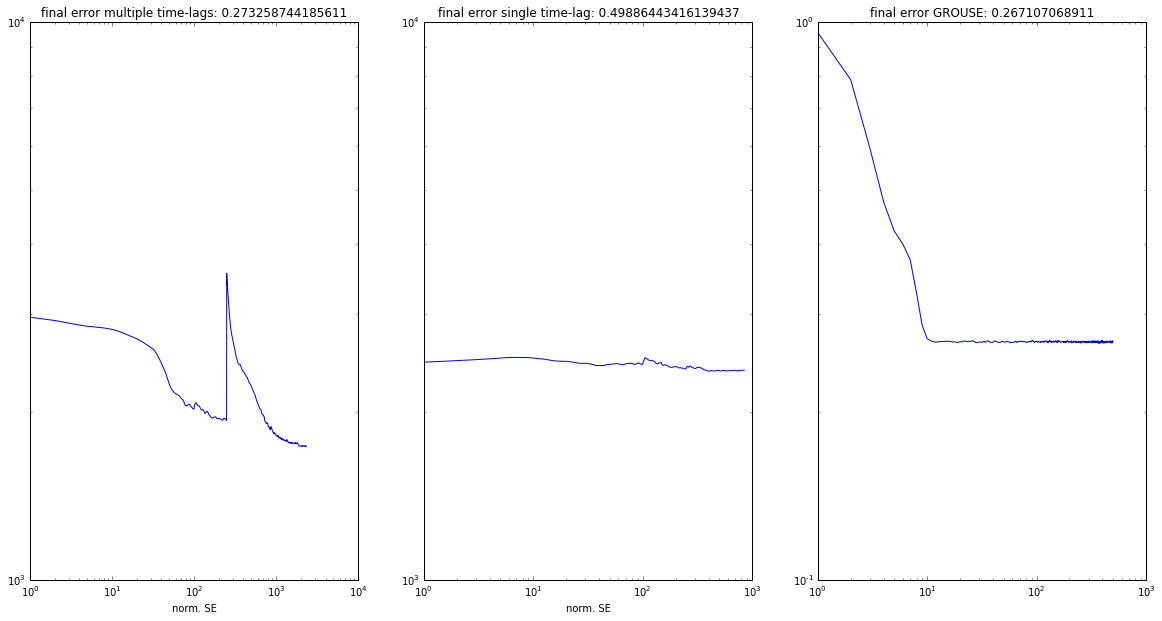

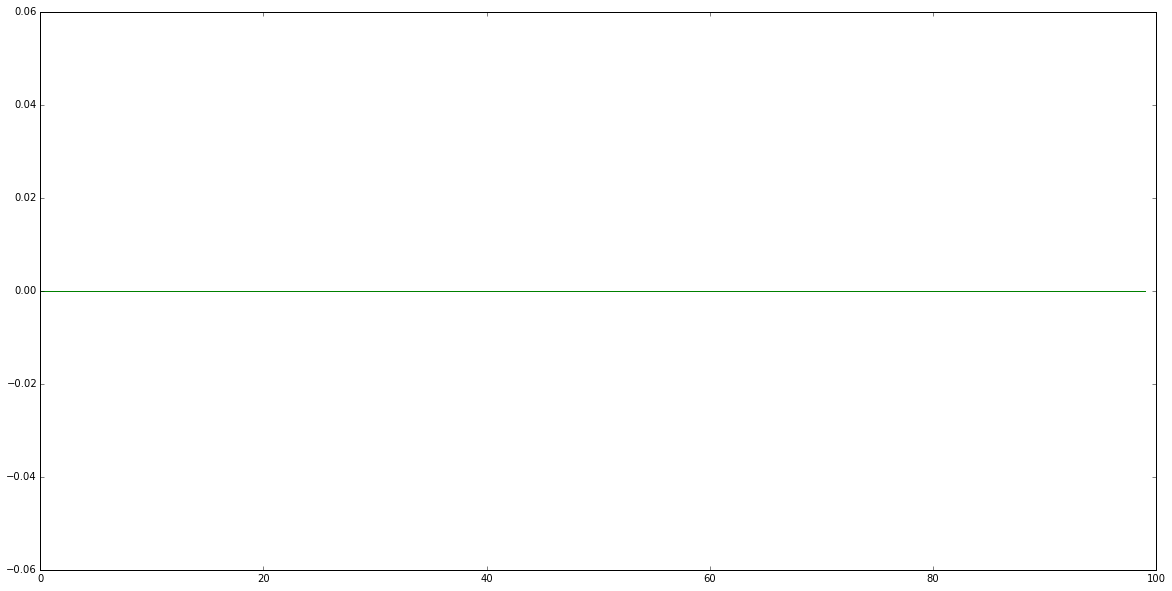

In [12]:
    # settings for quick initial SGD fitting phase for our model
    batch_size_late, max_zip_size_late, max_iter_late = 350, np.inf, 500
    a_late, b1_late, b2_late, e_late = 0.001, 0.9, 0.99, 1e-8
    a_R_late = 1 * a_late

    # fit our model with multiple time-lags
    print('\n - multiple lags')
    t = time.time()
    lag_range = lag_range_full.copy()
    proj_errors = np.zeros((max_iter, 2))
    def pars_track(C,X,R,t): 
        proj_errors[t,0] = calc_subspace_proj_error(pars_true['C'], C)
    #_, pars_est_m, traces_m = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
    #                                      obs_scheme=obs_scheme,init=pars_est_m,
    #                                      alpha_C=a,alpha_R=a_R,b1_C=b1,b2_C=b2,e_C=e,max_iter=max_iter,
    #                                      batch_size=batch_size,verbose=verbose, max_zip_size=max_zip_size,
    #                                      pars_track=pars_track)
    proj_errors_late = np.zeros((max_iter_late, 2))    
    def pars_track(C,X,R,t): 
        proj_errors_late[t,0] = calc_subspace_proj_error(pars_true['C'], C)
    _, pars_est_m, traces_m2 = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
                                          obs_scheme=obs_scheme,init=pars_est_m,
                                          alpha_C=a_late,alpha_R=a_R_late,b1_C=b1_late,b2_C=b2_late,e_C=e_late,
                                          max_iter=max_iter_late,batch_size=batch_size_late,
                                          verbose=verbose, max_zip_size=max_zip_size_late,pars_track=pars_track)
    traces_m = (np.hstack((traces_m[0], traces_m2[0])), np.hstack((traces_m[1], traces_m2[1])))
    t_m = time.time() - t
    print_slim(Qs,lag_range,pars_est_m,idx_a,idx_b,traces_m,mmap,data_path)
    print('fitting time was ', t_m, 's')
    print('rank of final C_est: ', sp.linalg.orth(pars_est_m['C']).shape[1])
    print('final proj. error: ', str(calc_subspace_proj_error(pars_true['C'], pars_est_m['C'])))

    rgt[run, 0] = f_l2_Hankel_nl(C=pars_true['C'],
                                 X=np.vstack([np.cov(x[k_:-(kl_+1)+k_, :].T, x[:-(kl_+1), :].T)[:n,n:] for k_ in lag_range]),
                                 Pi=np.cov(x.T),
                                 R=pars_true['R'],lag_range=lag_range,Qs=Qs,
                                 idx_grp=idx_grp,co_obs=co_obs,idx_a=idx_a,idx_b=idx_b)
    print('final error: ' + str(traces_m[0][-1]))    
    print('ground-truth reference error: ' + str(rgt[run,0]))

    
    res[run,:] = np.array([ calc_subspace_proj_error(pars_true['C'], pars_est_m['C']),
                            calc_subspace_proj_error(pars_true['C'], pars_est_s['C']),
                            error[-1]])
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.loglog(traces_m[0])
    plt.xlabel('norm. SE')
    plt.title('final error multiple time-lags: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_m['C'])))    
    plt.subplot(1,3,2)
    plt.loglog(traces_s[0])
    plt.xlabel('norm. SE')
    plt.title('final error single time-lag: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_s['C'])))
    plt.subplot(1,3,3)
    plt.loglog(range(1,max_iter_grouse+1), error)
    plt.title('final error GROUSE: ' + str(error[-1]))
    plt.show()
    
    plt.figure(figsize=(20,10))
    plt.plot(proj_errors[:,0])
    plt.hold(True)
    plt.plot(proj_errors[:,1])
    plt.show()


 - multiple lags
starting descent
finished % 10.0
f =  1737.70920954
finished % 20.0
f =  1736.36358213
finished % 30.0
f =  1736.46755768
finished % 40.0
f =  1734.35892994
finished % 50.0
f =  1733.87142487
finished % 60.0
f =  1734.1645409
finished % 70.0
f =  1736.26802354
finished % 80.0
f =  1733.27249599
finished % 90.0
f =  1733.96438441
finished % 100.0
f =  1734.97584938
total iterations:  2000
m = 0, corr = 0.928573681498
m = 1, corr = 0.914199273117
m = 2, corr = 0.905792877136
m = 3, corr = 0.896658460197
m = 4, corr = 0.883884775641
m = 5, corr = 0.870356762046
m = 6, corr = 0.85553426591
m = 7, corr = 0.841503991027
m = 8, corr = 0.825269137037
m = 9, corr = 0.808601498774
fitting time was  2571.442823410034 s
rank of final C_est:  10
final proj. error:  0.27785314063630145
final error: 1737.35037492
ground-truth reference error: 2517.08170748


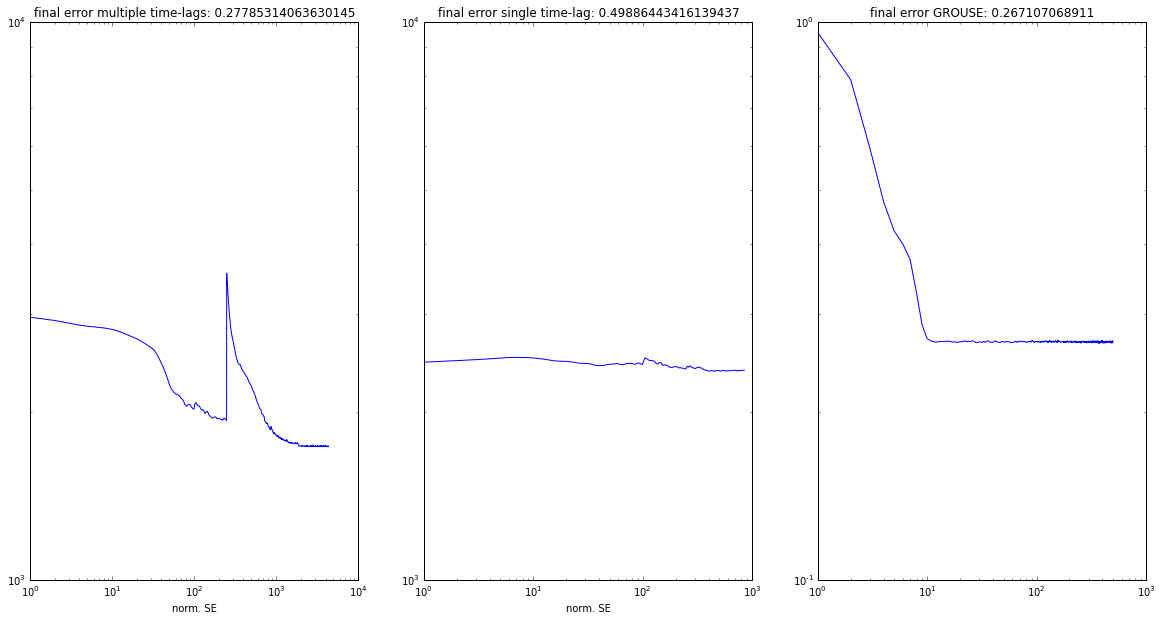

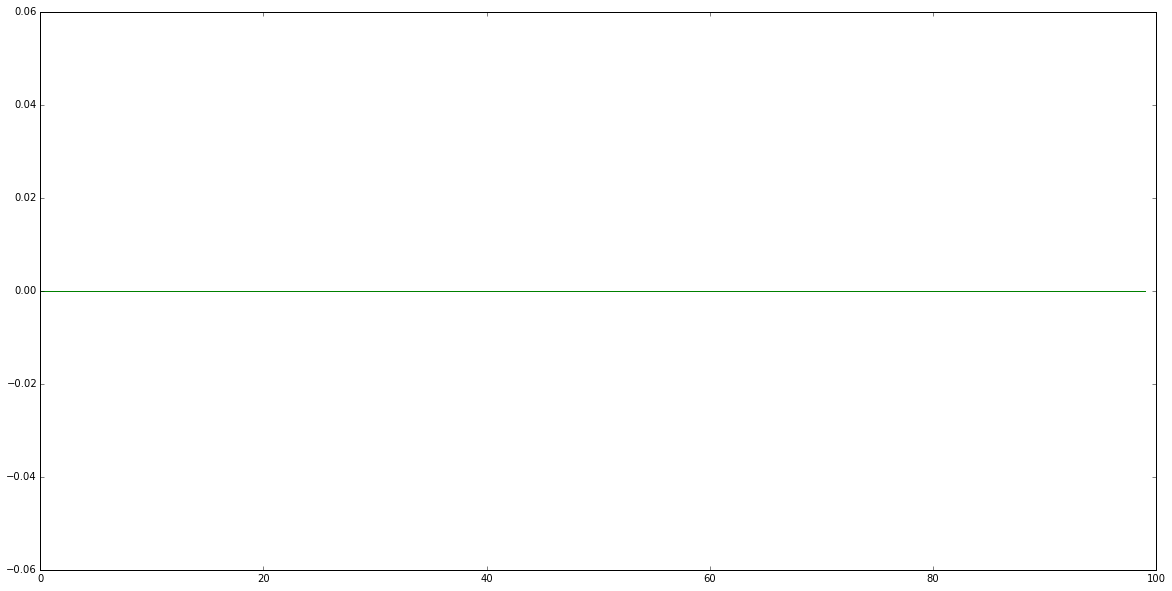

In [13]:
    # settings for quick initial SGD fitting phase for our model
    batch_size_late, max_zip_size_late, max_iter_late = 380, np.inf, 2000
    a_late, b1_late, b2_late, e_late = 0.001, 0.9, 0.99, 1e-8
    a_R_late = 1 * a_late

    # fit our model with multiple time-lags
    print('\n - multiple lags')
    t = time.time()
    lag_range = lag_range_full.copy()
    proj_errors = np.zeros((max_iter, 2))
    def pars_track(C,X,R,t): 
        proj_errors[t,0] = calc_subspace_proj_error(pars_true['C'], C)
    #_, pars_est_m, traces_m = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
    #                                      obs_scheme=obs_scheme,init=pars_est_m,
    #                                      alpha_C=a,alpha_R=a_R,b1_C=b1,b2_C=b2,e_C=e,max_iter=max_iter,
    #                                      batch_size=batch_size,verbose=verbose, max_zip_size=max_zip_size,
    #                                      pars_track=pars_track)
    proj_errors_late = np.zeros((max_iter_late, 2))    
    def pars_track(C,X,R,t): 
        proj_errors_late[t,0] = calc_subspace_proj_error(pars_true['C'], C)
    _, pars_est_m, traces_m2 = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
                                          obs_scheme=obs_scheme,init=pars_est_m,
                                          alpha_C=a_late,alpha_R=a_R_late,b1_C=b1_late,b2_C=b2_late,e_C=e_late,
                                          max_iter=max_iter_late,batch_size=batch_size_late,
                                          verbose=verbose, max_zip_size=max_zip_size_late,pars_track=pars_track)
    traces_m = (np.hstack((traces_m[0], traces_m2[0])), np.hstack((traces_m[1], traces_m2[1])))
    t_m = time.time() - t
    print_slim(Qs,lag_range,pars_est_m,idx_a,idx_b,traces_m,mmap,data_path)
    print('fitting time was ', t_m, 's')
    print('rank of final C_est: ', sp.linalg.orth(pars_est_m['C']).shape[1])
    print('final proj. error: ', str(calc_subspace_proj_error(pars_true['C'], pars_est_m['C'])))

    rgt[run, 0] = f_l2_Hankel_nl(C=pars_true['C'],
                                 X=np.vstack([np.cov(x[k_:-(kl_+1)+k_, :].T, x[:-(kl_+1), :].T)[:n,n:] for k_ in lag_range]),
                                 Pi=np.cov(x.T),
                                 R=pars_true['R'],lag_range=lag_range,Qs=Qs,
                                 idx_grp=idx_grp,co_obs=co_obs,idx_a=idx_a,idx_b=idx_b)
    print('final error: ' + str(traces_m[0][-1]))    
    print('ground-truth reference error: ' + str(rgt[run,0]))

    
    res[run,:] = np.array([ calc_subspace_proj_error(pars_true['C'], pars_est_m['C']),
                            calc_subspace_proj_error(pars_true['C'], pars_est_s['C']),
                            error[-1]])
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.loglog(traces_m[0])
    plt.xlabel('norm. SE')
    plt.title('final error multiple time-lags: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_m['C'])))    
    plt.subplot(1,3,2)
    plt.loglog(traces_s[0])
    plt.xlabel('norm. SE')
    plt.title('final error single time-lag: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_s['C'])))
    plt.subplot(1,3,3)
    plt.loglog(range(1,max_iter_grouse+1), error)
    plt.title('final error GROUSE: ' + str(error[-1]))
    plt.show()
    
    plt.figure(figsize=(20,10))
    plt.plot(proj_errors[:,0])
    plt.hold(True)
    plt.plot(proj_errors[:,1])
    plt.show()


 - multiple lags
starting descent
finished % 10.0
f =  1737.66973212
finished % 20.0
f =  1731.83996021
finished % 30.0
f =  1732.22376724
finished % 40.0
f =  1731.95135172
finished % 50.0
f =  1731.22051204
finished % 60.0
f =  1732.96984533
finished % 70.0
f =  1731.58216823
finished % 80.0
f =  1731.705033
finished % 90.0
f =  1731.26029319
finished % 100.0
f =  1732.12539067
total iterations:  2000
m = 0, corr = 0.931553318765
m = 1, corr = 0.916788964828
m = 2, corr = 0.907334961649
m = 3, corr = 0.896684945758
m = 4, corr = 0.884194157193
m = 5, corr = 0.870606335387
m = 6, corr = 0.85451644607
m = 7, corr = 0.839470906103
m = 8, corr = 0.822993274307
m = 9, corr = 0.805558742326
fitting time was  2518.3655922412872 s
rank of final C_est:  10
final proj. error:  0.2719911828901466
final error: 1731.44718087
ground-truth reference error: 2517.08170748


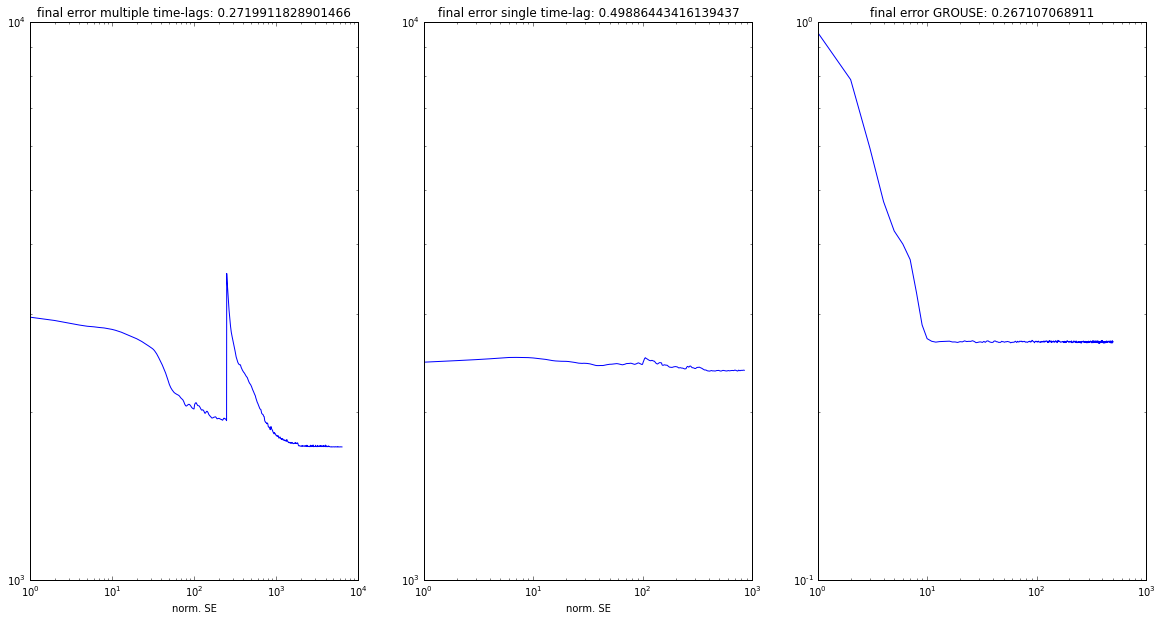

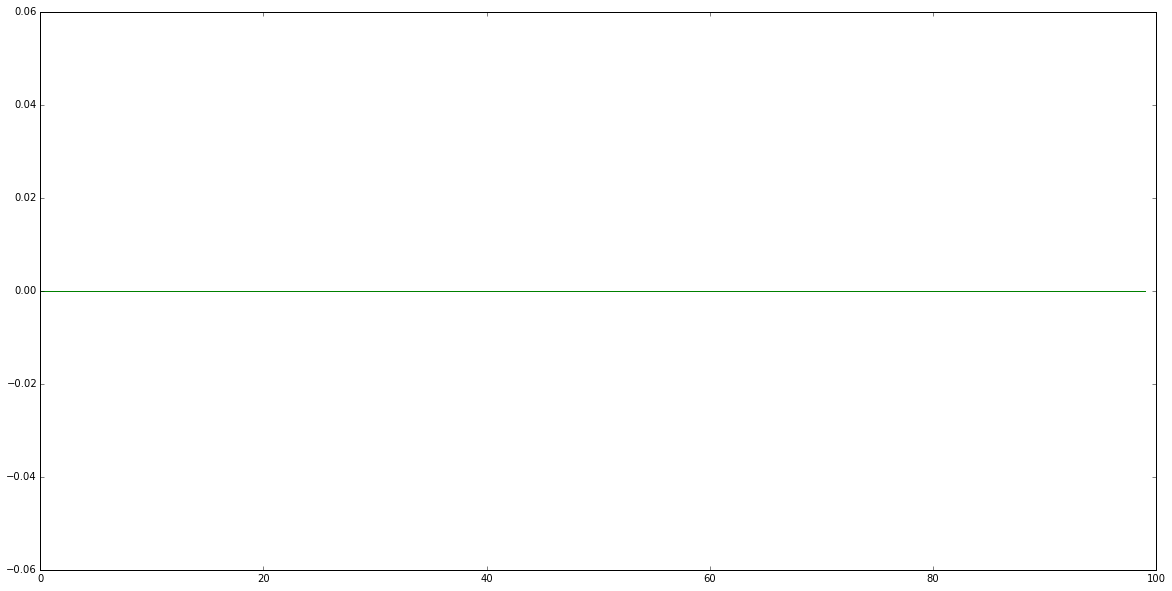

In [14]:
    # settings for quick initial SGD fitting phase for our model
    batch_size_late, max_zip_size_late, max_iter_late = 380, np.inf, 2000
    a_late, b1_late, b2_late, e_late = 0.0002, 0.9, 0.99, 1e-8
    a_R_late = 1 * a_late

    # fit our model with multiple time-lags
    print('\n - multiple lags')
    t = time.time()
    lag_range = lag_range_full.copy()
    proj_errors = np.zeros((max_iter, 2))
    def pars_track(C,X,R,t): 
        proj_errors[t,0] = calc_subspace_proj_error(pars_true['C'], C)
    #_, pars_est_m, traces_m = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
    #                                      obs_scheme=obs_scheme,init=pars_est_m,
    #                                      alpha_C=a,alpha_R=a_R,b1_C=b1,b2_C=b2,e_C=e,max_iter=max_iter,
    #                                      batch_size=batch_size,verbose=verbose, max_zip_size=max_zip_size,
    #                                      pars_track=pars_track)
    proj_errors_late = np.zeros((max_iter_late, 2))    
    def pars_track(C,X,R,t): 
        proj_errors_late[t,0] = calc_subspace_proj_error(pars_true['C'], C)
    _, pars_est_m, traces_m2 = run_bad(lag_range=lag_range,n=n,y=y, Qs=Qs,idx_a=idx_a, idx_b=idx_b,
                                          obs_scheme=obs_scheme,init=pars_est_m,
                                          alpha_C=a_late,alpha_R=a_R_late,b1_C=b1_late,b2_C=b2_late,e_C=e_late,
                                          max_iter=max_iter_late,batch_size=batch_size_late,
                                          verbose=verbose, max_zip_size=max_zip_size_late,pars_track=pars_track)
    traces_m = (np.hstack((traces_m[0], traces_m2[0])), np.hstack((traces_m[1], traces_m2[1])))
    t_m = time.time() - t
    print_slim(Qs,lag_range,pars_est_m,idx_a,idx_b,traces_m,mmap,data_path)
    print('fitting time was ', t_m, 's')
    print('rank of final C_est: ', sp.linalg.orth(pars_est_m['C']).shape[1])
    print('final proj. error: ', str(calc_subspace_proj_error(pars_true['C'], pars_est_m['C'])))

    rgt[run, 0] = f_l2_Hankel_nl(C=pars_true['C'],
                                 X=np.vstack([np.cov(x[k_:-(kl_+1)+k_, :].T, x[:-(kl_+1), :].T)[:n,n:] for k_ in lag_range]),
                                 Pi=np.cov(x.T),
                                 R=pars_true['R'],lag_range=lag_range,Qs=Qs,
                                 idx_grp=idx_grp,co_obs=co_obs,idx_a=idx_a,idx_b=idx_b)
    print('final error: ' + str(traces_m[0][-1]))    
    print('ground-truth reference error: ' + str(rgt[run,0]))

    
    res[run,:] = np.array([ calc_subspace_proj_error(pars_true['C'], pars_est_m['C']),
                            calc_subspace_proj_error(pars_true['C'], pars_est_s['C']),
                            error[-1]])
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.loglog(traces_m[0])
    plt.xlabel('norm. SE')
    plt.title('final error multiple time-lags: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_m['C'])))    
    plt.subplot(1,3,2)
    plt.loglog(traces_s[0])
    plt.xlabel('norm. SE')
    plt.title('final error single time-lag: ' + str(calc_subspace_proj_error(pars_true['C'], pars_est_s['C'])))
    plt.subplot(1,3,3)
    plt.loglog(range(1,max_iter_grouse+1), error)
    plt.title('final error GROUSE: ' + str(error[-1]))
    plt.show()
    
    plt.figure(figsize=(20,10))
    plt.plot(proj_errors[:,0])
    plt.hold(True)
    plt.plot(proj_errors[:,1])
    plt.show()

In [ ]:
plt.figure(figsize=(10,10))
kl_ = np.max(lag_range_full)
tmp = np.sqrt(np.diag(np.cov(x[:-(kl_+1)].T)))
print('empirical std: ' + str(tmp))
tmp = np.outer(tmp,tmp)
tmp_est = np.sqrt(np.diag(pars_est_m['X'][:n, :]))
tmp_est = np.outer(tmp_est, tmp_est)
for k in range(len(lag_range_full)):
    k_ = lag_range_full[k]
    plt.subplot(len(lag_range_full),2,2*(k)+1)
    plt.imshow(np.cov(x[k_:-(kl_+1)+k_, :].T, x[:-(kl_+1), :].T)[:n,n:]/tmp, interpolation='None')
    plt.colorbar()
    plt.title('k = ' + str(k))
    
    plt.subplot(len(lag_range_full),2,2*(k+1))
    plt.imshow(pars_est_m['X'][(k)*n:(k+1)*n,:] / tmp_est, interpolation='None')
    plt.colorbar()
    plt.title('k = ' + str(k))
    
plt.show()
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(x[:,0], x[:,1], '.')
plt.subplot(1,2,2)
plt.plot(x)
plt.show()
    

In [ ]:
res = res[:run,:]
rgt = rgt[:run,:]
algorithms = ['SSID 4 lags', 'SSID 1 lag', 'GROUSE']

plt.figure(figsize=(6,6))
plt.plot([0,1], [0,1], 'k')
plt.hold(True)
plt.plot(res[:,2], res[:,0], '.')
plt.xlabel(algorithms[2])
plt.ylabel(algorithms[0])
plt.plot()


plt.figure(figsize=(6,6))
plt.plot([0,1], [0,1], 'k')
plt.hold(True)
plt.plot(res[:,2], res[:,1], '.')
plt.xlabel(algorithms[2])
plt.ylabel(algorithms[1])
plt.plot()


plt.figure(figsize=(6,6))
plt.plot([0,1], [0,1], 'k')
plt.hold(True)
plt.plot(res[:,1], res[:,0], '.')
plt.xlabel(algorithms[1])
plt.ylabel(algorithms[0])
plt.plot()

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.hist(res[:,0], bins=np.linspace(0,1,21))
plt.title('projection errors ' + algorithms[0] )
plt.subplot(1,3,2)
plt.hist(res[:,1], bins=np.linspace(0,1,21))
plt.title('projection errors ' + algorithms[1] )
plt.subplot(1,3,3)
plt.hist(res[:,2], bins=np.linspace(0,1,21))
plt.title('projection errors ' + algorithms[2] )
plt.show()


In [ ]:
%matplotlib inline

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.imshow(np.cov(y.T), interpolation='None')
plt.colorbar()

plt.subplot(1,3,2)
pars_est = pars_est_s
plt.imshow(pars_est['C'].dot(pars_est['X'][:n,:]).dot(pars_est['C'].T) + np.diag(pars_est['R']),interpolation='None')
plt.colorbar()

plt.subplot(1,3,3)
pars_est = pars_est_m
plt.imshow(pars_est['C'].dot(pars_est['X'][:n,:]).dot(pars_est['C'].T) + np.diag(pars_est['R']),interpolation='None')
plt.colorbar()

plt.show()

plt.imshow(pars_true['C'].dot(pars_true['Pi']).dot(pars_true['C'].T)  + np.diag(pars_true['R']),interpolation='None')
plt.colorbar()
plt.show()

plt.imshow(Qs[0], interpolation='None')
plt.colorbar()
plt.show()
